In [23]:
# libraries
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
# local imports
import MNIST_dataloader
from scipy import linalg
import os
import bokeh
from ISTA import ISTAI_main
PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
print('Folders in the Fast_MRI_Knee:',os.listdir(PATH)) # os.listdir(PATH)
# Batch size
batch_size = 64
# Load train and test
train_loader, test_loader = MNIST_dataloader.create_dataloaders(PATH, batch_size)

if  torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Load data
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

Folders in the Fast_MRI_Knee: ['MNIST', 'test', 'train']


# Week1 
## Exercise 2
## Learned ISTA (LISTA)

In this section, we need to evlove the ISTA into a set of neural netowrk layers. Before to do so, recap of ISTA for sparse decoding problem is following:

$$
\begin{equation}
    x^{k+1}=\mathacal{T}_\lambda(x^k-\mu A^T(Ax^k-y))
\end{equation}
$$

In [14]:
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from matplotlib.image import imread
import numpy as np
from scipy import linalg
import torch

import torch.nn as nn
import torch.nn.functional as F
import Fast_MRI_dataloader 
batch_size = 64

class Fast_MRI(Dataset):
    # initialization of the dataset
    def __init__(self, split,data_loc):
        # save the input parameters
        self.split    = split 
        self.data_loc = data_loc
        
        # get all the files
        self.file_names = glob.glob(f"{data_loc}//{split}//*.npz")
    
    # return the number of examples in this dataset
    def __len__(self):
        return len(self.file_names)*5
    
    # create a a method that retrieves a single item form the dataset
    def __getitem__(self, idx):
        file_name = self.file_names[idx//5]
        data = np.load(file_name)
        
        kspace = data['kspace']
        M = data['M']
        gt = data['gt']
        
        # get one of 3 slices
        kspace = kspace[idx%5,:,:]
        gt = gt[idx%5,:,:]
        
        return kspace, M, gt

# PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
# print(PATH)

# train_loader, test_loader = Fast_MRI_dataloader.create_dataloaders(PATH, batch_size)



## LISTA Function


$$
\begin{equation*}
    x^{k+1} = \Tau_\lambda(W_1y+W_2x^k)
\end{equation*}
$$

$$
\begin{equation}
    \Tau_\lambda((I-\mu A^TA)x+\mu Ay)
\end{equation}
$$

In [15]:
from torch.autograd import Variable
class smoother(nn.Module):
    def __init__(self):
        # ,mu,shrinkage,K,y
        super(smoother,self).__init__()
        self.weight = Variable(torch.ones(1),requires_grad=True)
        
    def forward(self,x):
        """smooth forwarder
        return x + 0.5*(torch.sqrt( torch.square(x + self.weight) + 1) - torch.sqrt( torch.square(x + self.weight) + 1) )
        """

        x = x + 0.5*(torch.sqrt( torch.square(x + self.weight) + 1) - torch.sqrt( torch.square(x + self.weight) + 1) )
        return x



class LISTA_(nn.Module):
    def __init__(self,k=3):
        super(LISTA_,self).__init__()
        """ 2 convolutional layers & 1 smoother layer """
        self.x = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1) 
        self.y = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1) 
        self.k = k
        self.smoother = nn.ModuleList(smoother() for i in range(self.k))
        

    def forward(self,y):
        x = torch.zeros_like(y,requires_grad=False)
        for i in range(self.k):
            y_ = self.y(y)
            x_ = self.x(x)
            x = self.smoother[i](y_+x_)
        # x_init = torch.tensor(np.random.randn(64, 1, 32, 32), dtype=torch.float)
        # recon = 0

        # x1 = self.x(x_init)
        # y1 = self.y(y)
        # recon =recon+ self.smoother(x1+y1)

        # x2 = self.x(recon)
        # y2 = self.y(y)
        # recon =recon+ self.smoother(x2+y2)

        # x3 = self.x(recon)
        # y3 = self.y(y)
        # recon =recon+ self.smoother(x3+y3)

        # x = x + 0.5*(torch.sqrt( torch.square(x + self.weight) + 1) - torch.sqrt( torch.square(x + self.weight) + 1) )
        return x


for batch_idx,(x_clean,x_noisy,_) in enumerate(tqdm(train_loader)):
    inputs = x_noisy

print(inputs.shape)


md = LISTA_(3)

x = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1) 

X = md(inputs)
# sanity check
print('smoother inputs',md(inputs).shape)




100%|██████████| 938/938 [00:01<00:00, 652.90it/s]

torch.Size([32, 1, 32, 32])
smoother inputs torch.Size([32, 1, 32, 32])


In [16]:
# Optimizer
learning_rate = 1e-2
model = LISTA_()

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)



In [17]:
import sys
from tqdm import tqdm
loss_iter = []
loss_epoch = []
critereon = nn.MSELoss()
no_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"



for epoch in range(no_epochs):
    total_loss = 0
    sys.stdout.flush()
    for batch_idx,(x_clean,x_noisy,_) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = x_noisy.to(device=device)
        inputs = inputs+1
        # print(inputs.size())
        # inputs = torch.flatten(inputs)+1
        # print(inputs.size())
        model = model.to(device=device)
        outputs = model(inputs)

        loss = critereon(outputs,x_clean)
        loss.backward()
        optimizer.step()
        loss_iter.append(loss.data)
        total_loss += loss.data
    loss_epoch.append(total_loss/len(train_loader))
    print(f'epoch[{epoch+1}/{no_epochs}],MSE loss:{total_loss/len(train_loader)}')
    sys.stdout.flush()

100%|██████████| 938/938 [00:49<00:00, 18.85it/s]

epoch[1/10],MSE loss:0.08594486117362976



100%|██████████| 938/938 [00:47<00:00, 19.89it/s]

epoch[2/10],MSE loss:0.04214052855968475



100%|██████████| 938/938 [00:47<00:00, 19.66it/s]

epoch[3/10],MSE loss:0.04181186854839325



100%|██████████| 938/938 [00:42<00:00, 22.11it/s]

epoch[4/10],MSE loss:0.04166259616613388



100%|██████████| 938/938 [00:39<00:00, 23.66it/s]

epoch[5/10],MSE loss:0.04145469889044762



100%|██████████| 938/938 [00:38<00:00, 24.36it/s]

epoch[6/10],MSE loss:0.04123285412788391



100%|██████████| 938/938 [00:42<00:00, 22.17it/s]

epoch[7/10],MSE loss:0.04115963354706764



100%|██████████| 938/938 [00:46<00:00, 20.14it/s]

epoch[8/10],MSE loss:0.04113089293241501



100%|██████████| 938/938 [00:44<00:00, 21.16it/s]

epoch[9/10],MSE loss:0.04110682010650635



100%|██████████| 938/938 [00:45<00:00, 20.53it/s]

epoch[10/10],MSE loss:0.04110778868198395


In [19]:
from bokeh.plotting import figure,show
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
y = np.array(loss_epoch)
x = np.linspace(0,len(loss_epoch),num=len(loss_epoch))
p = figure(title='EX1 c part',y_axis_label='ISTA_loss', x_axis_label='Iteration')
p.line(x, y,line_width=2)
show(p,notebook_handle=True)
output_notebook()

Loading BokehJS ...

In [28]:
# torch.save(model, 'model_ex2.pth')
reconses = dict()
reconses[0]=model(x_noisy_example[0,:,:,:])
reconses[0].size().reshap

torch.Size([1, 32, 32])

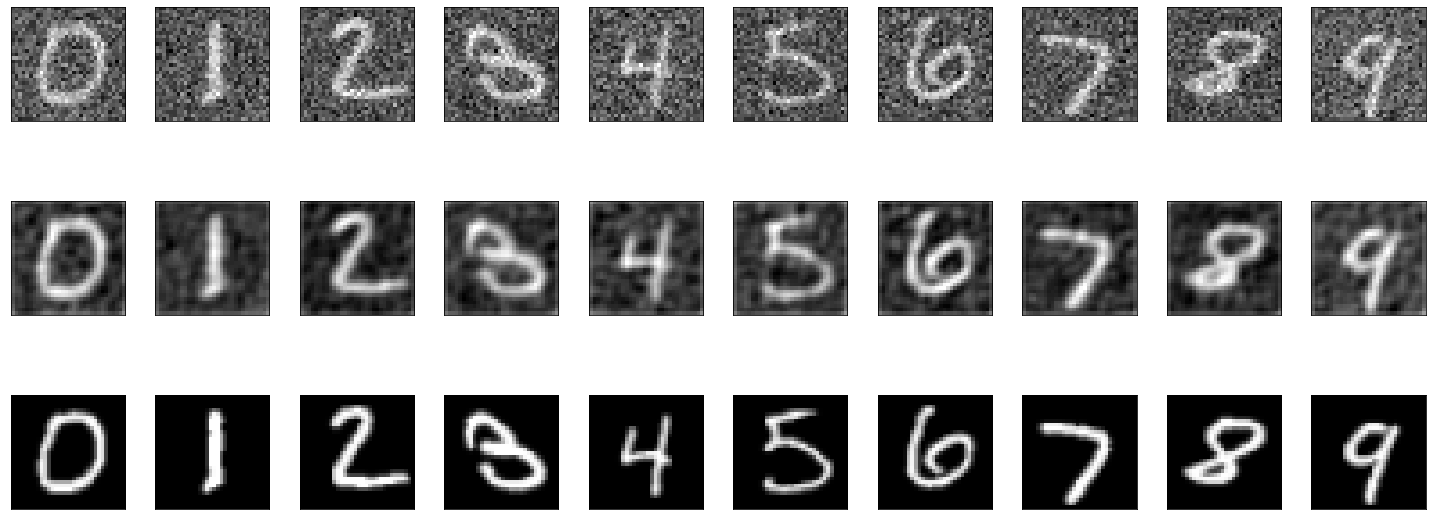

In [29]:
# use these 10 examples as representations for all digits
# x_clean_example = x_clean[0:10,:,:,:]
# x_noisy_example = x_noisy[0:10,:,:,:]
# labels_example = outputs[0:10]


import matplotlib.pyplot as plt
outputs.size()
reconses = dict()
fig = plt.figure(figsize=(20,10))
for i in range(10):
    reconses[i] = model(x_noisy_example[i,:,:,:])
    plottable_image = reconses[i].reshape([32,32])
    ax1 = fig.add_subplot(3, 10, i+1)
    ax1.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()

    # plottable_image = outputs[i,0,:,:]
    ax = fig.add_subplot(3, 10, i+11)
    ax.imshow(plottable_image.detach().numpy(),cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
    ax2 = fig.add_subplot(3, 10, i+21)
    ax2.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
Image_path = os.path.join(os.getcwd(),'Image')